# Import Library

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import torch

# Read Dataset

In [56]:
TRAIN_PATH = 'dataset/train/_annotations.csv'
TEST_PATH = 'dataset/test/_annotations.csv'
VALIDATION_PATH = 'dataset/valid/_annotations.csv'

TRAIN_IMAGES_PATH = 'dataset/train/images'
TEST_IMAGES_PATH = 'dataset/test/images'
VALIDATION_IMAGES_PATH = 'dataset/valid/images'

In [57]:
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,51c6a730cd2148cf_png.rf.8215c534a6a8965f48d3e4...,640,640,bald,144,136,463,296
1,0d68b408f99447db_png.rf.84b31c06c89c39aad59b37...,640,640,stage1,185,120,601,296
2,12c25ef865bb42f4_png.rf.83d97fda3647150ce7010b...,640,640,bald,191,121,494,291
3,2c8b63c20ae04544_png.rf.861ef2f7d5f4438094f21b...,640,640,stage1,166,153,557,284
4,5bf1b66a759e4a1d_png.rf.8532dba20adb44f0cd5ef8...,640,640,bald,138,88,483,286


In [58]:
test_data = pd.read_csv(TEST_PATH)
test_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,00f3803234f94362_png.rf.e19436380b41524690b06c...,640,640,stage2,147,77,516,287
1,06c6d8af209045ef_png.rf.f7fbfa579a3a986abb8ffc...,640,640,stage2,40,99,474,290
2,7b1a7bac342744e8_png.rf.ef38c4ac0cd88b3bb7128d...,640,640,stage2,111,105,476,294
3,4fa4cfaf860a4893_png.rf.e452ffa7501a295ae74fb5...,640,640,normal,55,95,512,293
4,6ff56310cb404774_png.rf.e9a3dfa46ca8d389bd0591...,640,640,stage2,102,63,520,298


In [59]:
validation_data = pd.read_csv(VALIDATION_PATH)
validation_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0c63639f8c0843e3_png.rf.1dc3b347beb1ced4e7080a...,640,640,stage1,133,113,521,291
1,5dd62b25c1cb49b0_png.rf.1f9a77f9d4295ad8600f54...,640,640,bald,152,137,502,296
2,9eadac6f97af49db_png.rf.288efbcbfb431f8e812924...,640,640,stage1,165,93,538,273
3,61b7fb0523694b9f_png.rf.1e15424d1b370d3f33dcf3...,640,640,normal,184,145,548,278
4,0c63dee11a5f4714_png.rf.2593b9e6550e8183e3c33e...,640,640,stage1,109,61,508,287


In [60]:
def storeImagesAnnotation(data, images_path, show_labels='training'):
    # Create lists to store the images and their respective labels
    images = []
    labels = []
    total_rows = len(data)
    # Loop through each row in the dataframe
    for _, row in tqdm(data.iterrows(), total=total_rows, desc=f'Processing Images of {show_labels} set'):
        image_path = os.path.join(images_path, row['filename'])

        # Read the image using OpenCV
        image = cv2.imread(image_path)

        images.append(image)
        labels.append(row['class'])
    
    return images, labels

def showImages(images, labels, n_images=10):
    n_cols = (n_images + 1) // 2
    n_rows = 2

    fig_width = 15
    fig_height = (n_rows / 2) * 7
    # Read images of grayscale
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i in range(n_images):
        fig.add_subplot(n_rows, n_cols, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

In [61]:
train_images, train_labels = storeImagesAnnotation(train_data, TRAIN_IMAGES_PATH)
test_images, test_labels = storeImagesAnnotation(test_data, TEST_IMAGES_PATH, show_labels='test')
validation_images, validation_labels = storeImagesAnnotation(validation_data, VALIDATION_IMAGES_PATH, show_labels='validation')

Processing Images of validation set: 100%|██████████| 302/302 [00:01<00:00, 164.53it/s]


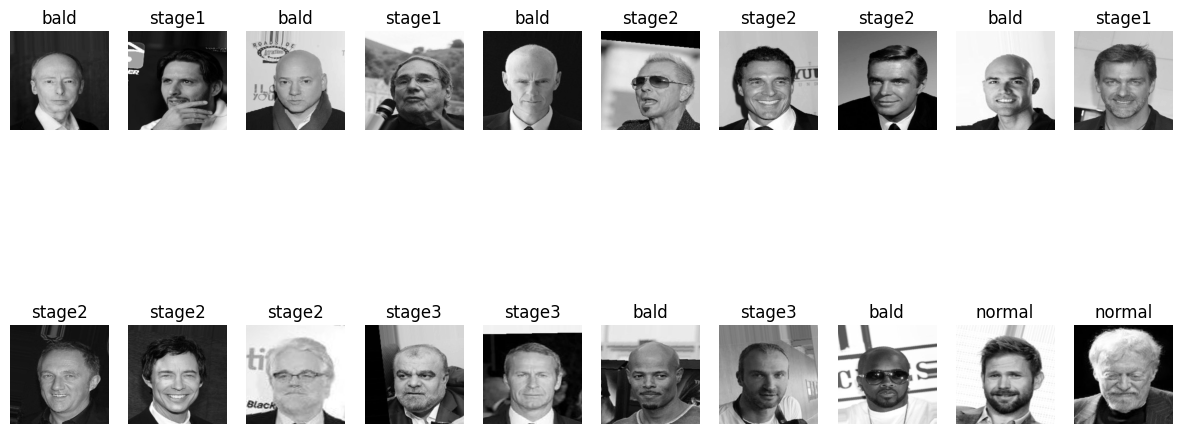

In [62]:
showImages(train_images, train_labels, 20)

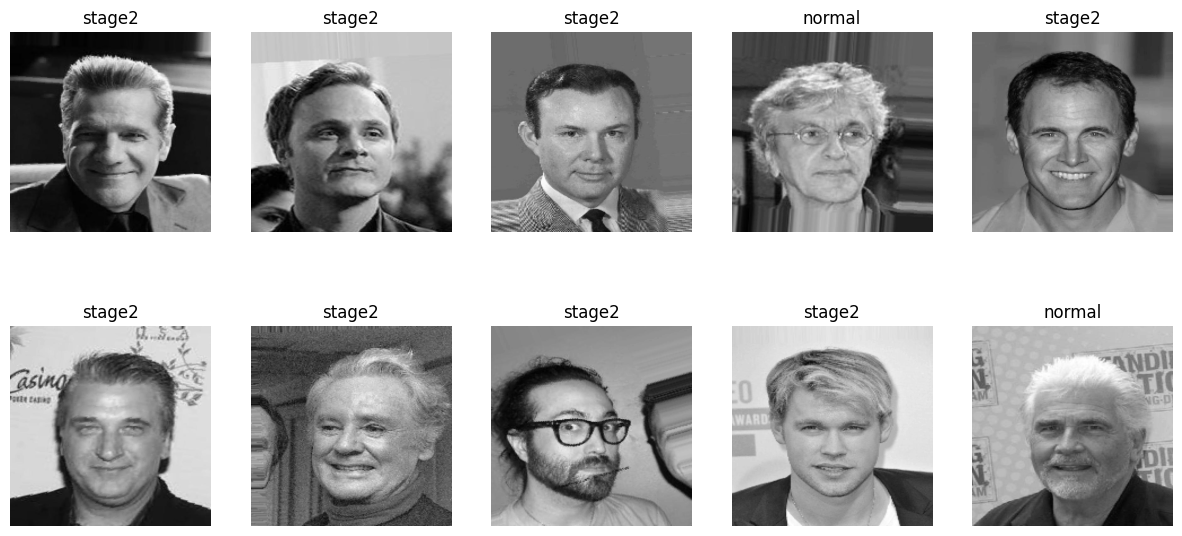

In [63]:
showImages(test_images, test_labels, 10)

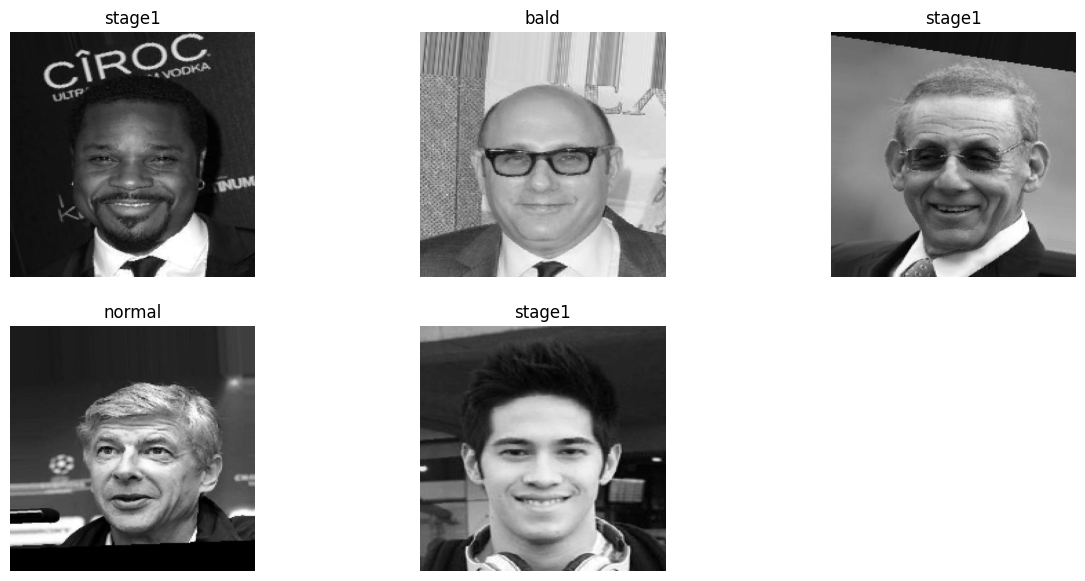

In [64]:
showImages(validation_images, validation_labels, 5)

In [65]:
list(set(train_labels))

['stage1', 'normal', 'bald', 'stage3', 'stage2']

# Pre-process Data

Define functions to resize images into 28x28, apply grayscale, reshape images and then normalize data

In [78]:
def resizeImages(images_train=train_images, images_test=test_images, images_validation=validation_images, new_height=28, new_width=28):
    resized_train_images = [cv2.resize(img, (new_width, new_height)) for img in images_train]
    resized_test_images = [cv2.resize(img, (new_width, new_height)) for img in images_test]
    resized_validation_images = [cv2.resize(img, (new_width, new_height)) for img in images_validation]
    return np.array(resized_train_images), np.array(resized_test_images), np.array(resized_validation_images)

def grayscaleImages(images_train, images_test, images_validation):
    grayscale_images_train = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_train]
    grayscale_images_test = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_test]
    grayscale_images_validation = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_validation]
    return np.array(grayscale_images_train), np.array(grayscale_images_test), np.array(grayscale_images_validation)

def reshapeImages(train_images, test_images, validation_images):
    number_pix = train_images.shape[1] * train_images.shape[2] * train_images.shape[3]
    X_train = train_images.reshape(train_images.shape[0], number_pix).astype('float32')
    X_test = test_images.reshape(test_images.shape[0], number_pix).astype('float32')
    X_validation = validation_images.reshape(validation_images.shape[0], number_pix).astype('float32')
    return X_train, X_test, X_validation

def normalizeData(train_images, test_images, validation_images):
    X_train = train_images / 255
    X_test = test_images / 255
    X_validation = validation_images / 255
    return X_train, X_test, X_validation

def categoricalImages(train_labels=train_labels, test_labels=test_labels, validation_labels=validation_labels):
    y_train = to_categorical(train_labels)
    y_test = to_categorical(test_labels)
    y_validation = to_categorical(validation_labels)
    return y_train, y_test, y_validation

def preprocessData(train_labels=train_labels, test_labels=test_labels, validation_labels=validation_labels): 
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)
    validation_labels_encoded = label_encoder.transform(validation_labels)
    y_train, y_test, y_validation = categoricalImages(train_labels_encoded, test_labels_encoded, validation_labels_encoded)
    return y_train, y_test, y_validation

In [82]:
X_train_resized, X_test_resized, X_validation_resized = resizeImages(train_images, test_images, validation_images, 50, 50)
X_train_grayscale, X_test_grayscale, X_validation_grayscale = grayscaleImages(X_train_resized, X_test_resized, X_validation_resized)
X_train_reshaped, X_test_reshaped, X_validation_reshaped = reshapeImages(X_train_resized, X_test_resized, X_validation_resized)
X_train_normalize, X_test_normalize, X_validation_normalize = normalizeData(X_train_reshaped, X_test_reshaped, X_validation_reshaped)

y_train, y_test, y_validation = preprocessData()

# Modelling